In [14]:
%matplotlib inline
# %matplotlib widget # 跟圖互動，可以用點選圖片中的某位置觸發程式
%env KERAS_BACKEND=tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from random import shuffle
# from matplotlib.widgets import Cursor, Button
from ipywidgets import interact, IntSlider, Button
from ipywidgets import interact_manual
import IPython.display as ipd
import networkx as nx # draw graph vertex & edge
import pydub # audio
from numpy.fft import fft, ifft # , irfft, rfft # fourier transform
# import sympy as sym
# from sympy import S,N
# import locale # 資料處理 轉換數字格式

# from sklearn.linear_model import LinearRegression
# from keras.utils import np_utils #one hot encoding
# from keras.models import Sequential #神經網路的框架keras.models
from keras.layers import Dense, Activation, Embedding
# from keras.layers import LSTM
from keras.layers import Flatten # 將資料展平
# from keras.layers import Conv2D, MaxPool2D, MaxPooling2D
from keras.layers import Conv1D, MaxPool1D, MaxPooling1D
from keras.optimizers import SGD, Adadelta, Adam
from keras.models import model_from_json
# from keras.datasets import mnist # mnist內 包含手寫測試資料
# from keras.datasets import imdb # imdb內 包含電影評論資料
# from keras.preprocessing import sequence # 用來同整不同長度的電影評論，多的擷掉，少的補 0
# from keras.preprocessing.text import Tokenizer # 轉換文字成數字
# from sklearn.model_selection import train_test_split

#for Functional API
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers import Reshape
# #for Functional API transfer learning
from keras.layers.core import Lambda
from keras import backend as K
from keras import metrics

# from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout

# import matplotlib.image as mpimg #import image file

env: KERAS_BACKEND=tensorflow


In [2]:
# import IPython.display as ipd
def playAudio(x, rate = 0):
    if type(x)!=np.ndarray:
        ipd.display(ipd.Audio(x))
    elif rate == 0:
        print("input rate!")
        return
    elif len(x.shape) > 1:
        ipd.display(ipd.Audio(x.T.astype(int), rate = rate))
    else:
        ipd.display(ipd.Audio(x.astype(int), rate = rate))

def read(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")

In [3]:
###################### skip ######################
# import pydub
# from pydub.playback import play
# pydub.AudioSegment.converter = "C:\\FFmpeg\\ffmpeg-20190604-d81913e-win64-static\\bin\\ffmpeg.exe"

# song = pydub.AudioSegment.from_mp3("jazz.mp3")

# play(song)
# pydub.playback(song)
###################### skip ######################

In [4]:
# out_array = song_array[:int(len(song_array)/10)]/100
# write('out.mp3', rate, out_array, normalized=False)

In [5]:
# playAudio('out.mp3') # ipd.Audio('out.mp3')
# playAudio(out_array, rate = rate) # ipd.Audio(out_array.T, rate = rate) # ipd.Audio(out_array[:,1], rate = rate)

In [6]:
# sr = 22050 # sample rate
# T = 2.0    # seconds
# t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
# x = 0.5 * np.sin(2*np.pi*440*t)
# playAudio(x, rate=sr) # ipd.Audio(x, rate = sr)

#### setting training data

In [3]:
rate, song_array = read('jazz.mp3', normalized=False)
print("frame_rate = ", rate, "(每秒鐘會產生", rate, "長度的陣列)\nsong_array = \n", song_array)
print("song_array.shape = ", song_array.shape)
chennel_length = 2
segement_length_sec = 2
segement_length = segement_length_sec * rate
train0 = song_array[0:segement_length * (song_array.shape[0]//segement_length)].copy()
train0 = train0.reshape(-1, segement_length, chennel_length).astype(float)
max_value = np.max(train0.reshape(-1))
min_value = np.min(train0.reshape(-1))
def normalize(data, max_value, min_value):
    data = data - min_value
    data = data / (max_value - min_value)
    return data
def inverse_normalize(data, max_value, min_value):
    data = data * (max_value - min_value)
    data = data + min_value
    return data
train0 = normalize(train0, max_value, min_value)

print("There are", train0.shape[0], "segements in train0.")
print("\ntrain0[87] = ", train0[87])

frame_rate =  48000 (每秒鐘會產生 48000 長度的陣列)
song_array = 
 [[  0   0]
 [  0   0]
 [  0   0]
 ...
 [-40 -62]
 [-24 -54]
 [  1 -20]]
song_array.shape =  (86401152, 2)
There are 900 segements in train0.

train0[87] =  [[0.49777981 0.46565957]
 [0.48760204 0.46366064]
 [0.42873274 0.4152285 ]
 ...
 [0.40015259 0.44693675]
 [0.41074235 0.47539483]
 [0.41205463 0.46970321]]


#### Show data

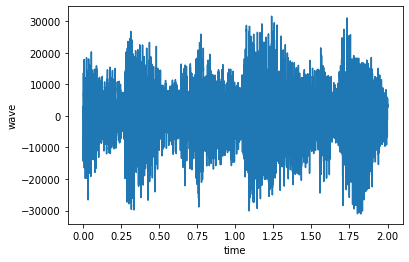

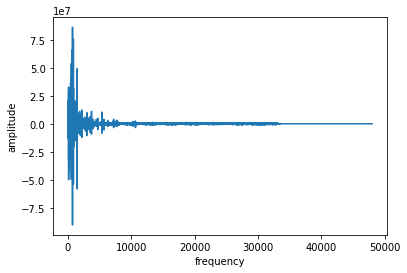

In [4]:
aud_data = song_array[segement_length*23:segement_length*24, 0].copy()

len_data = len(aud_data)
channel_1 = np.zeros(2**(int(np.ceil(np.log2(len_data)))))
channel_1[0:len_data] = aud_data
fourier = fft(channel_1)
t = np.linspace(0, segement_length_sec, len_data)
w = np.linspace(0, rate, len(fourier)//2)
fourier_to_plot = fourier[0:len(fourier)//2].real

plt.figure(1)
plt.plot(t, aud_data, label='aud_data')
plt.xlabel('time')
plt.ylabel('wave')
plt.figure(2)
plt.plot(w, fourier_to_plot, label='fourier_to_plot')
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.show()

#### modeling

In [22]:
# rate = 48000
chennel_length = 2
segement_length_sec = 2
segement_length = segement_length_sec * rate
input_dim = 10

x = Input(shape = (input_dim,), name='generator_x')
z = Dense(input_dim, activation='selu', name='generator_d1')(x)
z = Dense(input_dim, activation='selu', name='generator_d2')(z)
z = Dense(input_dim, activation='selu', name='generator_d3')(z)
# z = Dense(input_dim, activation='selu', name='generator_d4')(z)
# z = Dense(segement_length * chennel_length //10000, activation='selu', name='generator_d5')(z)
# z = Dense(segement_length * chennel_length //100, activation='selu', name='generator_d6')(z)
z = Dense(segement_length * chennel_length, activation='softmax', name='generator_d7')(z)
fake = Reshape((-1, chennel_length), name='generator_fake')(z)
generator = Model(x, fake, name='generator')
print(generator.summary())

data_input = Input(shape = (segement_length, chennel_length), name='discriminator_data_input')
z = Conv1D(4, rate//1000, padding = 'same', activation = 'selu', name='discriminator_c1')(data_input)
z = Conv1D(8, rate//1000, padding = 'same', activation = 'selu', name='discriminator_c2')(z)
z = Conv1D(16, rate//1000, padding = 'same', activation = 'selu', name='discriminator_c3')(z)
z = MaxPool1D(pool_size = rate//100, padding = 'same', name='discriminator_p1')(z)
z = Conv1D(4, rate//1000, padding = 'same', activation = 'selu', name='discriminator_c4')(z)
z = MaxPool1D(pool_size = rate//10000, padding = 'same', name='discriminator_p2')(z)
z = Conv1D(8, rate//1000, padding = 'same', activation = 'selu', name='discriminator_c5')(z)
z = MaxPool1D(pool_size = rate//10000, padding = 'same', name='discriminator_p3')(z)
z = Conv1D(4, rate//1000, padding = 'same', activation = 'selu', name='discriminator_c6')(z)
z = MaxPool1D(pool_size = rate//10000, padding = 'same', name='discriminator_p4')(z)
z = Flatten(name='discriminator_f1')(z)
solution = Dense(2, activation='softmax', name='discriminator_solution')(z)
discriminator = Model(data_input, solution, name='discriminator')
discriminator.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
print(discriminator.summary())

combined_input = Input(shape=(input_dim,), name='combined_input')
z = generator(combined_input)
discriminator.trainable = False
val = discriminator(z)
combined = Model(combined_input, val, name='combined')
combined.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
print(combined.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_x (InputLayer)     (None, 10)                0         
_________________________________________________________________
generator_d1 (Dense)         (None, 10)                110       
_________________________________________________________________
generator_d2 (Dense)         (None, 10)                110       
_________________________________________________________________
generator_d3 (Dense)         (None, 10)                110       
_________________________________________________________________
generator_d7 (Dense)         (None, 192000)            2112000   
_________________________________________________________________
generator_fake (Reshape)     (None, 96000, 2)          0         
Total params: 2,112,330
Trainable params: 2,112,330
Non-trainable params: 0
_________________________________________________________________


In [ ]:
generator = model_from_json(open('json_h5/GAN_generator.json').read())
discriminator = model_from_json(open('json_h5/GAN_discriminator.json').read())
combined = model_from_json(open('json_h5/GAN_combined.json').read())

generator.load_weights('json_h5/GAN_generator.h5')
discriminator.load_weights('json_h5/GAN_discriminator.h5')

generator.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
discriminator.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
combined.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [24]:
VAE_input = Input(shape=(segement_length, chennel_length), name='VAE_input')
z = Conv1D(4, rate//1000, padding = 'same', activation = 'selu', name='encoder_c1')(VAE_input)
z = Conv1D(8, rate//1000, padding = 'same', activation = 'selu', name='encoder_c2')(z)
z = Conv1D(16, rate//1000, padding = 'same', activation = 'selu', name='encoder_c3')(z)
z = MaxPool1D(pool_size = rate//100, padding = 'same', name='encoder_p1')(z)
z = Flatten(name='encoder_f1')(z)
z = Dense(input_dim, activation='selu', name='encoder_d1')(z)
z = Dense(input_dim, activation='selu', name='encoder_d2')(z)
# z = Dense(input_dim, activation='selu', name='encoder_d3')(z)
encoder_mean = Dense(input_dim, activation='selu', name='encoder_mean')(z)
encoder_log_var = Dense(input_dim, activation='selu', name='encoder_log_var')(z)

def VAE_sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(input_dim,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# VAE_input = Input(shape=(segement_length, chennel_length), name='VAE_input')
# z = encoder(VAE_input)
z = Lambda(VAE_sampling, output_shape=(input_dim,), name='encoder_L1')([encoder_mean, encoder_log_var])
VAE_output = generator(z)
VAE = Model(VAE_input, VAE_output, name='VAE')
def VAE_loss(x, x_recon):
    recovery_loss = segement_length * chennel_length * metrics.binary_crossentropy(x, x_recon)
    KL_loss = - 0.5 * K.sum(1 + encoder_log_var - K.square(encoder_mean) - K.exp(encoder_log_var), axis=-1)
    return recovery_loss + KL_loss
VAE.compile(loss=VAE_loss, optimizer=Adam(), metrics=['accuracy'])
print(VAE.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
VAE_input (InputLayer)          (None, 96000, 2)     0                                            
__________________________________________________________________________________________________
encoder_c1 (Conv1D)             (None, 96000, 4)     388         VAE_input[0][0]                  
__________________________________________________________________________________________________
encoder_c2 (Conv1D)             (None, 96000, 8)     1544        encoder_c1[0][0]                 
__________________________________________________________________________________________________
encoder_c3 (Conv1D)             (None, 96000, 16)    6160        encoder_c2[0][0]                 
__________________________________________________________________________________________________
encoder_p1

In [34]:
start = 150
end = start + 40
VAE.fit(train0[start:end], train0[start:end], batch_size = 1, epochs = 10);

Epoch 1/10
40/40 [==============================] - 13s 314ms/step - loss: 1167914.5094 - acc: 0.4986
Epoch 2/10
40/40 [==============================] - 12s 310ms/step - loss: 1167883.8594 - acc: 0.5112
Epoch 3/10
40/40 [==============================] - 13s 320ms/step - loss: 1167867.6656 - acc: 0.5259
Epoch 4/10
40/40 [==============================] - 13s 322ms/step - loss: 1167860.6219 - acc: 0.5302
Epoch 5/10
40/40 [==============================] - 13s 337ms/step - loss: 1167858.5781 - acc: 0.5318
Epoch 6/10
40/40 [==============================] - 14s 346ms/step - loss: 1167855.5406 - acc: 0.5338
Epoch 7/10
40/40 [==============================] - 14s 354ms/step - loss: 1167855.5969 - acc: 0.5337
Epoch 8/10
40/40 [==============================] - 15s 374ms/step - loss: 1167856.5938 - acc: 0.5343
Epoch 9/10
40/40 [==============================] - 16s 405ms/step - loss: 1167855.6063 - acc: 0.5344
Epoch 10/10
40/40 [==============================] - 16s 405ms/step - loss: 116784

In [35]:
def sampling(mean = 0, std = 1, batch = 1, input_dim = 10):
    return (np.random.normal(size = input_dim * batch) * std + mean).reshape(batch, input_dim)

def GAN(epochs = 1, batch = 16, times = 3):
    for i in range(epochs):
        print("\n****************************************\n   Epoch = ", i+1, "/", epochs)

        # batch = 16
        print("prepare data for discriminator...")
        x_train = np.zeros((batch * 2, segement_length, chennel_length))
        shu = np.arange(batch)
        shuffle(shu)
        for idx in range(batch):
            x_train[idx] = train0[shu[idx]].copy()
        samples = sampling(mean = 0, std = 10, batch = batch, input_dim = input_dim)
        x_train[batch:] = generator.predict(samples)
        y_train = np.zeros((batch * 2, 2))
        y_train[0:batch, 0] = np.ones(batch)
        y_train[batch:, 1] = np.ones(batch)
        print("discriminator training...")
        discriminator.fit(x_train, y_train, batch_size = batch * 2, shuffle = True, epochs = 1);

        print("prepare data for generator...")
        # times = 3
        x_train_combined = sampling(mean = 0, std = 1, batch = batch * times, input_dim = input_dim)
        y_train_combined = np.zeros((batch * times, 2))
        y_train_combined[:, 0] = np.ones(batch * times)
        print("generator training...")
        combined.fit(x_train_combined, y_train_combined, batch_size = batch, epochs = 1);

In [36]:
GAN(epochs = 2, batch = 32, times = 10)


****************************************
   Epoch =  1 / 2
prepare data for discriminator...
discriminator training...


c:\users\奎佑\appdata\local\programs\python\python36\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/1
64/64 [==============================] - 27s 423ms/step - loss: 0.5815 - acc: 0.5000
prepare data for generator...
generator training...
Epoch 1/1
320/320 [==============================] - 76s 236ms/step - loss: 0.7077 - acc: 0.0000e+00

****************************************
   Epoch =  2 / 2
prepare data for discriminator...
discriminator training...
Epoch 1/1
64/64 [==============================] - 20s 314ms/step - loss: 0.4043 - acc: 1.0000
prepare data for generator...
generator training...
Epoch 1/1
320/320 [==============================] - 74s 232ms/step - loss: 0.7465 - acc: 0.0000e+00


In [7]:
open('json_h5/GAN_generator.json','w').write(generator.to_json())
open('json_h5/GAN_discriminator.json','w').write(discriminator.to_json())
open('json_h5/GAN_combined.json','w').write(combined.to_json())

generator.save_weights('json_h5/GAN_generator.h5')
discriminator.save_weights('json_h5/GAN_discriminator.h5')

#### Let's generate some jazz

In [9]:
# samples = sampling(mean = 0, std = 1, batch = 1, input_dim = input_dim)
# predicts = generator.predict(samples)
# play_predicts = inverse_normalize(predicts[0].reshape(-1, chennel_length), max_value, min_value)
# playAudio(play_predicts, rate = rate)

In [10]:
# playAudio(song_array[segement_length*23:segement_length*24, 0], rate = rate)